# Gradient Boosting

In [128]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Read Data

In [129]:
#data from here https://www.kaggle.com/c/boston-housing/overview
df = pd.read_csv('https://raw.githubusercontent.com/shestakoff/hse_se_ml/master/2020/s11-boosting/data/boston_train.csv').drop(columns = 'ID')

 Prediction of house price in Boston.
 
 Why it's important? Because it can help people determine a fair price at home.

In [130]:
X = df.drop(columns = 'medv').values
y = df['medv'].values

In [131]:
X.shape

(333, 13)

## Before doing

definition of huber_loss: https://en.wikipedia.org/wiki/Huber_loss

Implement function which calculate $z_i$ from gradient boosting alogirithm (minus gradient of loss function). Implement for all possible loss function (mse, hl, logloss)

In hl use $\delta = 1$, assume that $MSE = \frac{1}{2}(r - y)^2$ and log_loss(sigmoid(r)) use $0$ and $1$ like class label

In [132]:
def calc_objective(r, target, loss = 'mse'):
    
    indx = 0
    size = r.shape[0]
    result_arr = np.empty(size)
        
    if loss == 'hl':
        
        values_arr = r - target
        
        for curValue in values_arr:
            if abs(curValue) <= 1:
                result_arr[indx] = -curValue
                indx += 1
            else:
                result_arr[indx] = np.sign(curValue) * -1
                indx += 1
                
    elif loss == 'logloss':
        
        for indx in range(0, size):
            
            if target[indx] == 0:
                result_arr[indx] = -1 / (1 + np.exp(-r[indx]))
            else:
                result_arr[indx] = (np.exp(-r[indx]*target[indx]) * target[indx]) \
                               / (1 + np.exp(-r[indx]*target[indx]))
                
    else:
        values_arr = r - target
        result_arr = -values_arr
                
    return result_arr

In [133]:
#test your code

r = np.array([1, 2, 3, 4, 5])
target = np.array([10, 9, 8, 7, 6])
assert(np.allclose(calc_objective(r, target, 'mse'), np.array([9, 7, 5, 3, 1]), 0.00001))

r = np.array([2, 4, 7, 9, 13])
target = np.array([2.5, 6, 10, 6, 12.75])
assert(np.allclose(calc_objective(r, target, 'hl'), np.array([0.5, 1, 1, -1, -0.25]), 0.00001))

r = np.array([0, np.log(2), -np.log(9), np.log(4), np.log(19)])
target = np.array([0, 1, 0, 1, 1])
assert(np.allclose(calc_objective(r, target, 'logloss'), np.array([-0.5, 1. / 3, -0.1, 0.2, 0.05]), 0.00001))

Implement function which make one step of gradient boossting (fit new estimator)

In [134]:
def step(X, y, r, base_estimator, loss = 'mse'):
    
    c = calc_objective(r, y, loss)

    fit_estimator = base_estimator.fit(X, c)

    return fit_estimator

## Now use your knowledge and implement gradient boosting

# Task 1 (6 points)

Implement GradientBoostingRegressor as it was described in your lectures:

**Input**: training dataset $(x_{i},y_{i}),\,i=1,2,...N$; loss function $\mathcal{L}(f,y)$; learning rate $\nu$ and the number $M$ of successive additive approximations.

1. Fit initial approximation $f_{0}(x)$ (might be taken $f_{0}(x)\equiv0$)
2. For each step $m=1,2,...M$:

    1. calculate derivatives $z_{i}=-\frac{\partial\mathcal{L}(r,y_{i})}{\partial r}|_{r=f^{m-1}(x_{i})}$
    2. fit $h_{m}$ to $\{(x_{i},z_{i})\}_{i=1}^{N}$, for example by solving
$$
\sum_{n=1}^{N}(h_{m}(x_{n})-z_{n})^{2}\to\min_{h_{m}}
$$
    4. set $f_{m}(x)=f_{m-1}(x)+\nu h_{m}(x)$


**Output**: approximation function $f_{M}(x)=f_{0}(x)+\sum_{m=1}^{M}\nu h_{m}(x)$

Implement three loss functions:

    1 MSE
    2 Huber loss(https://en.wikipedia.org/wiki/Huber_loss)
    3 log_loss (in this case we solve classification task
In our case $h_m$ is DecisionTreeRegressor

In [135]:
from sklearn.tree import DecisionTreeRegressor

In [136]:
class GradientBoostingEstimator(object):
    def __init__(self, n_estimators, max_depth=3, max_leaf_nodes=8, n_subset_features=5, random_state=42,
                 loss='mse', learning_rate=0.1):

        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.n_subset_features = n_subset_features
        self.max_leaf_nodes = max_leaf_nodes
        self.max_depth = max_depth
        self.loss = loss
        self.random_state = random_state

        self.tree_arr = []
        self.r_arr = []

    def fit(self, X, y):

        y_size = y.shape[0]
        self.r_arr = np.zeros(y_size)

        size = self.n_estimators

        for indx in range(size):
            dt = DecisionTreeRegressor(max_depth=self.max_depth,
                                       max_leaf_nodes=self.max_leaf_nodes,
                                       random_state=self.random_state)

            c = calc_objective(self.r_arr, y, self.loss)

            dt.fit(X, c)

            self.tree_arr.append(dt)
            self.r_arr = self.r_arr + self.learning_rate * dt.predict(X)


    def predict(self, X):

        x_size = X.shape[0]
        result = np.zeros(x_size)

        size = self.n_estimators

        for indx in range(0, size):
            result += self.learning_rate * self.tree_arr[indx].predict(X)

        return result

    def predict_proba(self, X):

        x_size = X.shape[0]
        result = np.zeros(x_size)

        size = self.n_estimators

        for indx in range(0, size):
            result += self.learning_rate * self.tree_arr[indx].predict(X)

        result = 1 / (1 + np.exp(-result))

        return result


### Important
When you select `learning_rate` and `n_estimators`, follow the default values of the tree parameters

# Task 2 (2 points)

Split your data on train, valid sample (fix random_seed). Choose the best `learning_rate` and `n_estimators` for every loss (for logloss use data from previous HW). For regression task (mse_loss, huber_loss) use MSE on valid sample as quality measure to choose optimal params, for classification task (logloss) use ROC-AUC.

In [137]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=50) 

In [138]:
def setReady():
    min_error, best_indx, best_lrate, lrateArr = 2**24, 0, 0, np.arange(0.01, 0.47, 0.05)
    
    return min_error, best_indx, best_lrate, lrateArr

In [139]:
min_error, best_indx, best_lrate, lrateArr = setReady()

for curlRate in lrateArr:
    
    for indx in range(1, 20, 1):
        
        clf = GradientBoostingEstimator(learning_rate=curlRate,
                                        n_estimators=indx, loss = 'mse')

        clf.fit(X_train,y_train)
    
        cur_min = np.power((1/y_test.shape[0]) * 
                           (clf.predict(X_test).mean() - y_test.mean()), 2)

        if min_error > cur_min:
            best_lrate = curlRate
            min_error = cur_min
            best_indx = indx


In [140]:
best_lrate

0.26

In [141]:
best_indx

17

In [142]:
min_error, best_indx, best_lrate, lrateArr = setReady()

for curlRate in lrateArr:
    
    for indx in range(1, 20, 1):
        
        clf = GradientBoostingEstimator(learning_rate=curlRate, 
                                        n_estimators=indx, loss = 'hl')

        clf.fit(X_train,y_train)
        
        cur_min = np.power((1/y_test.shape[0]) * 
                           (clf.predict(X_test).mean() - y_test.mean()),2)

        if min_error > cur_min:
            best_lrate = curlRate
            min_error = cur_min
            best_indx = indx


In [143]:
best_lrate

0.46

In [144]:
best_indx

19

In [159]:
from sklearn.metrics import roc_auc_score

X_df = pd.read_csv('./data/x_train.csv', sep=';')
y_df = pd.read_csv('./data/y_train.csv', sep=';', header=None, names=['target'])

In [160]:
print(X_df.head(5))

   maxPlayerLevel  numberOfAttemptedLevels  attemptsOnTheHighestLevel  \
0              39                       10                          3   
1              21                       22                         19   
2               5                        6                          1   
3              21                        2                          5   
4               4                        5                          1   

   totalNumOfAttempts  averageNumOfTurnsPerCompletedLevel  \
0                  17                           24.444444   
1                  55                           17.045455   
2                   6                            8.400000   
3                   6                           19.000000   
4                   5                            9.600000   

   doReturnOnLowerLevels  numberOfBoostersUsed  fractionOfUsefullBoosters  \
0                      1                     5                   0.400000   
1                      1                

In [161]:
X_data = X_df.values
y_data = y_df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.8,
                                                    random_state=50) 

In [162]:
score, best_indx, best_lrate = 0, 0, 0
lrateArr = np.arange(0.01, 0.47, 0.05)

for curlRate in lrateArr:
    
    for indx in range(1, 20, 1):
        
        clf = GradientBoostingEstimator(learning_rate=curlRate, 
                                        n_estimators=indx, loss = 'logloss')

        clf.fit(X_train,y_train)

        cur_score = roc_auc_score(y_test,clf.predict_proba(X_test))

        if score < cur_score:
            score = cur_score
            best_indx = indx
            best_lrate = curlRate

In [163]:
score

0.8760819734987044

In [164]:
best_indx

19

In [165]:
best_lrate

0.46

# Task 3 (1 point)
Plot dependecy of loss value (in classification task plot roc-auc score) from `n_estimators` of your boosting. Use `learning_rate=0.1`.

In [152]:
import matplotlib.pyplot as plt

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=50) 

In [154]:
indx_arr, result = np.arange(1, 20, 1), []

for indx in indx_arr:
    clf = GradientBoostingEstimator(n_estimators=indx, learning_rate=0.1, loss='mse')
    clf.fit(X_train, y_train)
    
    error = np.power((clf.predict(X_test) - y_test), 2) / 2
    sum = np.sum(error)
    
    result.append(sum)

result = np.array(result)

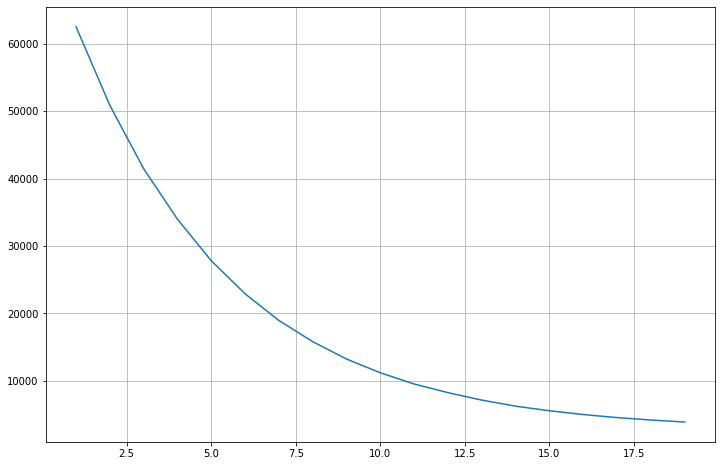

In [155]:
plt.figure(figsize=(12, 8))
plt.plot(indx_arr, result)
plt.grid()
plt.show()

In [120]:
indx_arr, result = np.arange(1, 200, 1), []

for indx in indx_arr:
    clf = GradientBoostingEstimator(n_estimators=indx, learning_rate=0.1, loss='hl')
    clf.fit(X_train, y_train)
    
    error = np.power((clf.predict(X_test) - y_test), 2) / 2
    sum = np.sum(error)
    
    result.append(sum)

result = np.array(result)

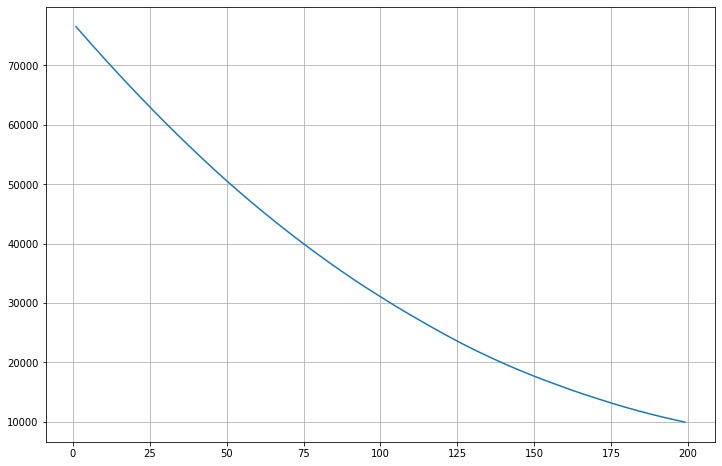

In [122]:
plt.figure(figsize=(12, 8))
plt.plot(indx_arr, result)
plt.grid()
plt.show()

In [123]:
X_df = pd.read_csv('./data/x_train.csv', sep=';')
y_df = pd.read_csv('./data/y_train.csv', sep=';', header=None, names=['target'])

In [124]:
print(X_df.head(5))

   maxPlayerLevel  numberOfAttemptedLevels  attemptsOnTheHighestLevel  \
0              39                       10                          3   
1              21                       22                         19   
2               5                        6                          1   
3              21                        2                          5   
4               4                        5                          1   

   totalNumOfAttempts  averageNumOfTurnsPerCompletedLevel  \
0                  17                           24.444444   
1                  55                           17.045455   
2                   6                            8.400000   
3                   6                           19.000000   
4                   5                            9.600000   

   doReturnOnLowerLevels  numberOfBoostersUsed  fractionOfUsefullBoosters  \
0                      1                     5                   0.400000   
1                      1                

In [125]:
X_data = X_df.values
y_data = y_df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.8,
                                                    random_state=50) 

In [126]:
indx_arr, result, score = np.arange(1, 20, 1), [], 0

for indx in indx_arr:
    clf = GradientBoostingEstimator(n_estimators=indx, learning_rate=0.1, loss='logloss')
    clf.fit(X_train, y_train)
    
    score = roc_auc_score(y_test, clf.predict(X_test))
    
    result.append(score)

result = np.array(result)

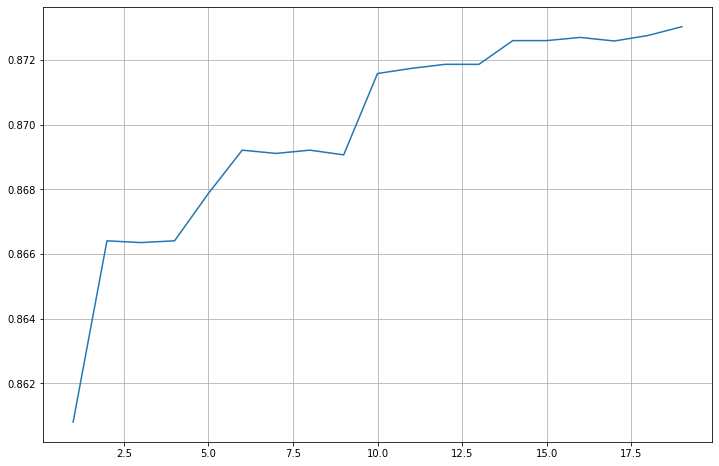

In [127]:
plt.figure(figsize=(12, 8))
plt.plot(indx_arr, result)
plt.grid()
plt.show()

# Task 4 (1 point)
Plot dependecy of loss value (in classification task plot roc-auc score) from `learning_rate` of your boosting. Use `n_estimators=100`.

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=50) 

In [167]:
lrateArr, result = np.arange(0.01, 0.47, 0.05), []

for curlRate in lrateArr:
    clf = GradientBoostingEstimator(n_estimators=100, learning_rate=curlRate, loss='mse')
    clf.fit(X_train, y_train)
    
    error = np.power((clf.predict(X_test) - y_test), 2) / 2
    sum = np.sum(error)
    
    result.append(sum)

result = np.array(result)

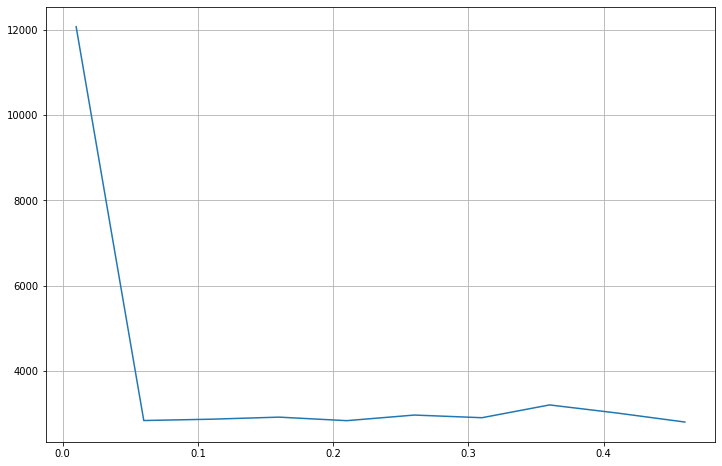

In [170]:
plt.figure(figsize=(12, 8))
plt.plot(lrateArr, result)
plt.grid()
plt.show()

In [178]:
lrateArr, result = np.arange(0.01, 0.47, 0.05), []

for curlRate in lrateArr:
    clf = GradientBoostingEstimator(n_estimators=100, learning_rate=curlRate, loss='hl')
    clf.fit(X_train, y_train)
    
    error = np.power((clf.predict(X_test) - y_test), 2) / 2
    sum = np.sum(error)
    
    result.append(sum)

result = np.array(result)

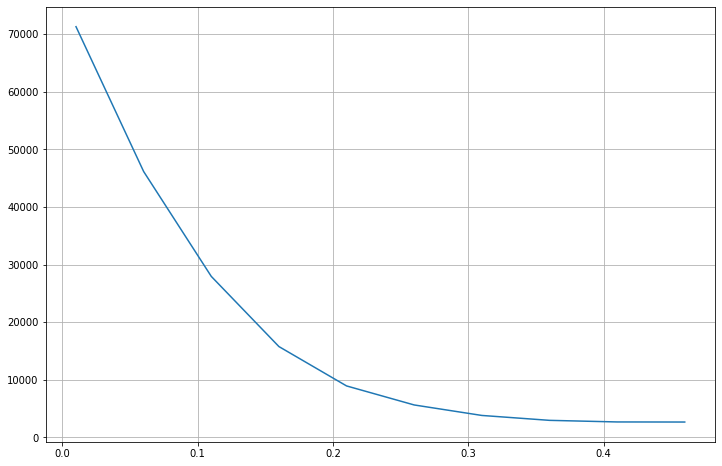

In [179]:
plt.figure(figsize=(12, 8))
plt.plot(lrateArr, result)
plt.grid()
plt.show()

In [180]:
X_df = pd.read_csv('./data/x_train.csv', sep=';')
y_df = pd.read_csv('./data/y_train.csv', sep=';', header=None, names=['target'])

In [181]:
print(X_df.head(5))

   maxPlayerLevel  numberOfAttemptedLevels  attemptsOnTheHighestLevel  \
0              39                       10                          3   
1              21                       22                         19   
2               5                        6                          1   
3              21                        2                          5   
4               4                        5                          1   

   totalNumOfAttempts  averageNumOfTurnsPerCompletedLevel  \
0                  17                           24.444444   
1                  55                           17.045455   
2                   6                            8.400000   
3                   6                           19.000000   
4                   5                            9.600000   

   doReturnOnLowerLevels  numberOfBoostersUsed  fractionOfUsefullBoosters  \
0                      1                     5                   0.400000   
1                      1                

In [182]:
X_data = X_df.values
y_data = y_df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.8,
                                                    random_state=50) 

In [186]:
lrateArr, result, score = np.arange(0.01, 0.47, 0.05), [], 0

for curlRate in lrateArr:
    clf = GradientBoostingEstimator(n_estimators=100, learning_rate=curlRate, loss='logloss')
    clf.fit(X_train, y_train)
    
    score = roc_auc_score(y_test, clf.predict(X_test))
    
    result.append(score)

result = np.array(result)

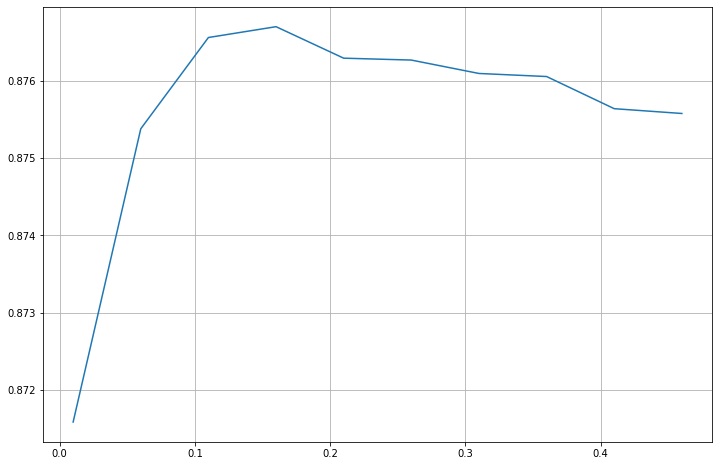

In [187]:
plt.figure(figsize=(12, 8))
plt.plot(lrateArr, result)
plt.grid()
plt.show()